# Summary
In Season 12, the strike zone formula is this:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.90,
                 minroll
                 + 0.35*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 13, the strike zone formula is modified. The The max possible value for a strike goes DOWN from 0.90 to 0.85, and the ruthlessness coefficient goes DOWN from 0.35 to 0.30. This formula holds for Season 13 and Season 14:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.85,
                 minroll
                 + 0.3*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 15, the strike zone formula changes slightly *again*. The max possible value for a strike goes UP from 0.85 to 0.86, and the ruthlessness coefficient goes DOWN from 0.3 to 0.285 (a 5% decrease):
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.86,
                 minroll
                 + 0.285*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```


In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

In [2]:
all_files = glob.glob("../roll_data/*-strikes.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
# seasons = [11,12,13,14]
season = 18
df = df[df['season'] == season]


flinch_data = False

## Helper function definitions

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # sometimes traveling doesn't do anything on pitchers, but not always
        # if not row["top_of_inning"]:
            # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        pass # sometimes growth doesn't do anything on pitchers, but not always
        # mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        # mul += 1.25
        pass
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.50
    return mul

## Apply multipliers to data

In [4]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

df["ruth_scaled"] = df["pitcher_ruthlessness"] * df["pitcher_mul"]
df["cold_scaled"] = df["pitcher_coldness"] * df["pitcher_mul"]
df["opw_scaled"] = df["pitcher_overpowerment"] * df["pitcher_mul"]
df["unthwk_scaled"] = df["pitcher_unthwackability"] * df["pitcher_mul"]
df["shakes_scaled"] = df["pitcher_shakespearianism"] * df["pitcher_mul"]
df["supp_scaled"] = df["pitcher_suppression"] * df["pitcher_mul"]

df["musc_scaled"] = df["batter_musclitude"] * df["batter_mul"]
df["mox_scaled"] = df["batter_moxie"] * df["batter_mul"]
df["path_scaled"] = df["batter_patheticism"] * df["batter_mul"]


df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [5]:
# recenter ballpark factors: subtract 0.5
for attr in ['ballpark_grandiosity',
             'ballpark_fortification',
             'ballpark_obtuseness',
             'ballpark_ominousness',
             'ballpark_inconvenience',
             'ballpark_viscosity',
             'ballpark_forwardness',
             'ballpark_mysticism',
             'ballpark_elongation',
            ]:
    df[attr] -= 0.50


In [368]:
df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)]

df["ruth_times_vibes"] = df["ruth_scaled"] * df["pitcher_vibes"]
df["ruth_vibes"] = (df["ruth_scaled"] * (1 + 0.2 * df["pitcher_vibes"]))
df["cold_vibes"] = (df["cold_scaled"] * (1 + 0.2 * df["pitcher_vibes"]))
df["opw_vibes"] = df["opw_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["unthwk_vibes"] = df["unthwk_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["shakes_vibes"] = df["shakes_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["supp_vibes"] = df["supp_scaled"] * (1 + 0.2 * df["pitcher_vibes"])

df["musc_vibes"] = df["musc_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["mox_vibes"] = df["mox_scaled"] * (1 + 0.2 * df["batter_vibes"])

df["ruth_cold"] = (9 * df["ruth_vibes"] + 1 * df["cold_vibes"]) / 10
# df["ruth_cold"] = df["ruth_vibes"] * df["cold_scaled"]
df["musc_mox"] = df["musc_scaled"] * df["mox_scaled"]
df["musc_sq"] = df["musc_scaled"] ** 2
df["mox_sq"] = df["mox_scaled"] ** 2

powers = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9",
    "1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0",
         "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"]
for pow in powers:
    df["musc_"+pow] = df["musc_scaled"] ** float(pow)
    # df["musc_1.1"] = df["musc_scaled"] ** 1.1
    # df["musc_1.2"] = df["musc_scaled"] ** 1.2
    # df["musc_1.3"] = df["musc_scaled"] ** 1.3
    # df["musc_1.4"] = df["musc_scaled"] ** 1.4
    # df["musc_1.5"] = df["musc_scaled"] ** 1.5
    # df["musc_1.6"] = df["musc_scaled"] ** 1.6
    # df["musc_1.7"] = df["musc_scaled"] ** 1.7
    # df["musc_1.8"] = df["musc_scaled"] ** 1.8
    # df["musc_1.9"] = df["musc_scaled"] ** 1.9
    # df["musc_2.0"] = df["musc_scaled"] ** 2.0
    df["mox_"+pow] = df["mox_scaled"] ** float(pow)
    # df["mox_1.1"] = df["mox_scaled"] ** 1.1
    # df["mox_1.2"] = df["mox_scaled"] ** 1.2
    # df["mox_1.3"] = df["mox_scaled"] ** 1.3
    # df["mox_1.4"] = df["mox_scaled"] ** 1.4
    # df["mox_1.5"] = df["mox_scaled"] ** 1.5
    # df["mox_1.6"] = df["mox_scaled"] ** 1.6
    # df["mox_1.7"] = df["mox_scaled"] ** 1.7
    # df["mox_1.8"] = df["mox_scaled"] ** 1.8
    # df["mox_1.9"] = df["mox_scaled"] ** 1.9
    # df["mox_2.0"] = df["mox_scaled"] ** 2.0

df["roll_mod"] = df["roll"] - 0.29 * df["ruth_cold"] - 0.12 * df["ballpark_forwardness"] - 0.34
# df["roll_log"] = np.log(df["roll_mod"])
# df["musc_log"] = np.log(df["musc_scaled"])
# df["mox_log"] = np.log(df["mox_scaled"])
# df["musc_mox_log"] = np.log(df["musc_mox"])


# put in our "best fit" up here in the original df, just because
if season == 11:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.35 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 12 or season == 13:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.30 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 14:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.285 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]

## Exclude data
Handles swapping between flinch and no-flinch situations, and excluding things like ON_FIRE.

In [369]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df.copy()
for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST", "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST"]:
# for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    #     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    #     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc["flinch"] = (dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0)
    print(dfc.groupby("flinch").size())
    if flinch_data:
        dfc = dfc[dfc["flinch"]]
    else:
        dfc = dfc[~dfc["flinch"]]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)
# dfc.groupby("flinch").size()

# excluding one weird data point in season 18 that seems incorrect
for exclude_points in [("080c2816-0fff-4e55-bb9a-8dd547f4e3b1", 41),
                      ("7d782994-a4fb-469d-9942-e97def670e23", 168)]:
    dfc = dfc[~((dfc["game_id"] == exclude_points[0]) & (dfc["play_count"] == exclude_points[1]))]
   
   
   
# dfc["mox_pow"] = dfc["mox_scaled"]**1.0


flinch
False    11164
True       316
dtype: int64


In [370]:
# print(list(df.columns))
print(len(df))
print(len(dfc))

31601
11164


In [371]:
digest_list = [
    "event_type",
    "roll",
    "threshold",
    "batter_name",
    "pitcher_name",
    "ruth_vibes",
    # "pitcher_vibes",
    "musc_scaled",
    "mox_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    # "svc_best",
]

In [372]:
# old weighting functions, not using these

# dfc['svc'] = 0.37847946767478163 * dfc["pitcher_ruthlessness"] + 0.30163948661504275 * dfc["ballpark_forwardness"]
# # df['svc_vibes'] = 0.3570080647613859*df["pitcher_ruthlessness"] + 0.23460353690794863*df["ballpark_forwardness"] \
# #                   + 0.06376601180181157*df["pitcher_vibes"]
# dfc['svc_vibes'] = 0.35 * dfc["pitcher_ruthlessness"] + 0.25 * dfc["ballpark_forwardness"] \
#                   + 0.05 * dfc["pitcher_vibes"]
# dfc['svc_musc'] = 0.31647362 * dfc["pitcher_ruthlessness"] + 0.20359297 * dfc["ballpark_forwardness"] \
#                   + 0.05434203 * dfc["pitcher_vibes_multiplied"] + 0.09587699 * dfc["batter_musclitude"]
# dfc['batter_strikeattr'] = dfc['batter_moxie'] * ~dfc['passed'] + dfc['batter_patheticism'] * dfc['passed']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']

### Preliminary plot

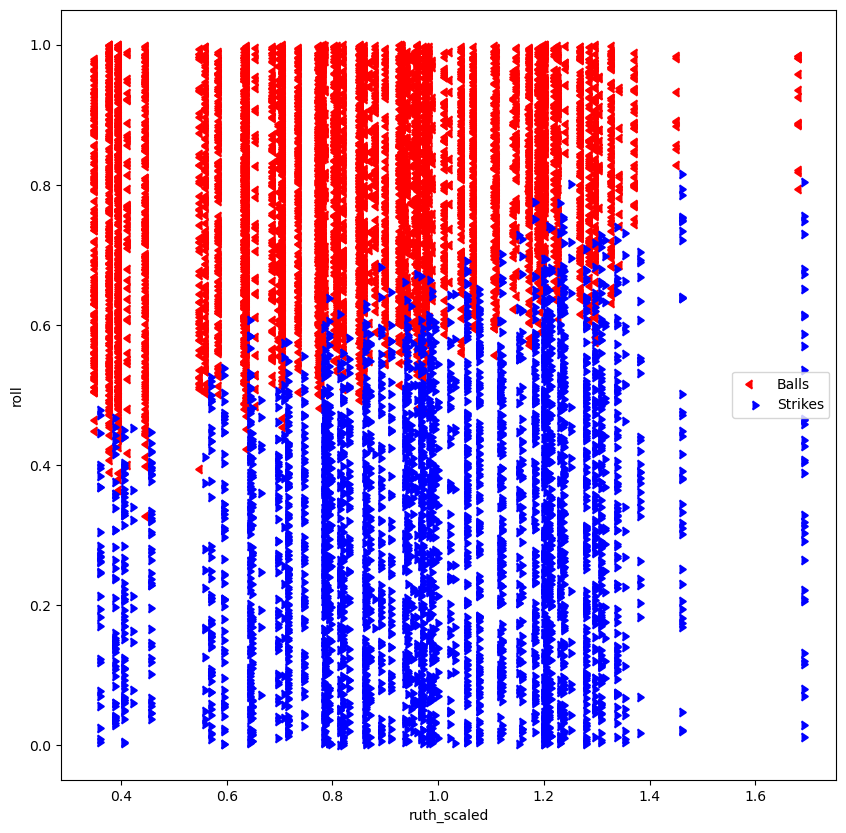

In [373]:
x_val = "ruth_scaled"
# x_val = "svc_best"
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig(x_val + ".png", facecolor="white")

In [374]:
dfc.groupby(["batting_team_mods"]).size()

batting_team_mods
0;SHAME_GIVER                                           37
AA;AFFINITY_FOR_CROWS                                   74
AAA                                                    546
AAA;SHAME_GIVER                                         43
ACIDIC;SUN2_PAYOUTS;SUN_KISSED                         256
ACIDIC;SUN_KISSED;SUN2_PAYOUTS                          63
AMBUSH;SEALANT;FIERY;FIREPROOF                         125
BASE_INSTINCTS                                         681
BASE_INSTINCTS;ELECTRIC                                 14
BASE_INSTINCTS;LATE_TO_PARTY;LIFE_OF_PARTY              58
BIRD_SEED                                              335
BLACKHOLE_PAYOUTS;BOTTOM_DWELLER                       471
BOTTOM_DWELLER;BLACKHOLE_PAYOUTS                       237
CARCINIZATION;0;UNHOLEY                                268
CARCINIZATION;AAA;UNHOLEY;0                             52
CARCINIZATION;UNHOLEY;0                                209
ELECTRIC;LIFE_OF_PARTY                

## SVC fit

In [407]:
# powers = ["1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0"]
dfc["musc_pow"] = dfc["musc_0.5"]
dfc["mox_pow"] = dfc["mox_1.5"]
dfc["musc_mox"] = dfc["musc_pow"] * dfc["mox_pow"]

In [436]:
# X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
X = dfc[["passed",
         "roll",
         # "roll_mod",
         # "roll_log",
         "ruth_vibes",
         "cold_vibes",
         # "ruth_cold",
         "ballpark_forwardness",
         # "musc_scaled",
         # "mox_scaled",
         "musc_mox",
         "musc_pow",
         "mox_pow",
         # "musc_log",
         # "mox_log",
         # "musc_mox_log",
         # "mox_vibes",
         # "batting_team_hype",
         # "pitching_team_hype",
         ]].copy()
X = X[X["roll"] < 0.86]
# attributes may or may not be allowed to go negative with items. exclude cases where this might happen
# and which would throw off the non-integer power i'm testing
X = X[~np.isnan(X.iloc[:,-1])]
X = X[~np.isnan(X.iloc[:,-2])]
# X = X[X["roll_mod"] > 0]
# X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop(["passed"], axis=1)
# X = X.drop(["roll"], axis=1)
# X = X.drop(["roll_mod"], axis=1)

pin_intercept = None
# pin_intercept = 0.34
pins = [
    # (-0.075, "batting_team_hype"),
    # (0.060, "pitching_team_hype"),
    # (0.29, "ruth_cold"),
    # (0.12, "ballpark_forwardness"),
    # (0.075, "musc_scaled"),
    # (-0.08, "mox_scaled"),
    # (0.08, "musc_mox"),
]
for val, var in pins:
    X["roll_log"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X["roll"].max())
print(X.shape)

0.8599502790290696
(8712, 7)


In [437]:
# dfc.loc[(dfc["batter_name"] == "Geepa Beanpot") & (dfc["mox_scaled"] < 0), "mox_scaled"]

In [438]:
# dfc.loc[dfc["pitching_team_mods"].astype(str).str.contains("FIREPROOF"), 
#             [
#         # "offset",  # "home_score", "away_score", "top_of_inning", "inning",
#         "pitcher_mul",
#         "batter_mul",
#         "event_type",
#         "roll",
#         # "threshold",
#         # "svc",
#         # "ruth_vibes",
#         "batter_vibes",
#         "batter_moxie",
#         # "ballpark_forwardness",
#         # "pitcher_coldness",
#         "batter_name",
#         "pitcher_name",
#         "batter_mods",
#         "pitcher_mods",
#         "batting_team_mods",
#         "pitching_team_mods",
#         "day",
#         "game_id",
#         "play_count",
#         "weather",
#          # 'ball_count',
#          # 'strike_count',
#          # 'out_count'
#     ]
#        ]

In [441]:

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

# sc = StandardScaler()
# X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

[[4684   10]
 [  21 3997]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4694
        True       1.00      0.99      1.00      4018

    accuracy                           1.00      8712
   macro avg       1.00      1.00      1.00      8712
weighted avg       1.00      1.00      1.00      8712

0.9964416896235078
0.31943915164238423 , intercept
(0.26478665407456586, 'ruth_vibes')
(0.0295712555511239, 'cold_vibes')
(0.11072062047391226, 'ballpark_forwardness')
(0.09911763768592066, 'musc_mox')
(0.06374824696049505, 'musc_pow')
(-0.15602796747486433, 'mox_pow')


## Calculate threshold from fit

In [442]:
if flinch_data:
    intercept = 0.50
else:
    intercept = 0.30
if season == 11:
    dfc["threshold"] = (intercept
                        + 0.35 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.90
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 12 or season == 13:
    dfc["threshold"] = (intercept
                        + 0.30 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season in [14, 15, 16, 17]:
    dfc["threshold"] = (intercept
                        + 0.285 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
# elif season == 18:
#     intercept = 0.275 # 1/3
#     dfc["threshold"] = (intercept
#                         + 0.275 * dfc["ruth_vibes"] # + 0.285 * dfc["ruth_vibes"]
#                         + 0.025 * dfc["cold_vibes"] # + 0.0285 * dfc["cold_vibes"]
#                         + 0.115 * dfc["ballpark_forwardness"] # + 0.125 * dfc["ballpark_forwardness"]
#                         + 0.075 * dfc["musc_scaled"] # + 0.08 * dfc["musc_scaled"]
#                         - 0.095 * dfc["mox_scaled"] # - 0.10 * dfc["mox_scaled"]
#                        )
#     dfc["svc"] = dfc["threshold"] - intercept
#     strikemax = 0.86
#     dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
else:
    intercept = intercept_scaled
    dfc['threshold'] = intercept_scaled
    print(intercept_scaled)
    for pair in pins + list(zip(-np.array(coef_list), X.columns)):
        if "roll" not in pair[1]:
            print(pair)
            dfc['threshold'] += pair[0] * dfc[pair[1]]
    # dfc['threshold'] += 0.2 * dfc['ballpark_forwardness']
    dfc["svc"] = dfc["threshold"] - intercept_scaled
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax


# dfc['svc'] = 0
# # print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         # print(pair)
#         dfc['svc'] += pair[0] * dfc[pair[1]]
# dfc['svc'] += 0.2 * dfc['ballpark_forwardness']

# kidror's rounding:
#  0.275 + 0.275*ruth + 0.115*dfc["ballpark_forwardness"] + 0.075*dfc["batter_musclitude"]
# - 0.095*dfc["batter_moxie"] + 0.025*cold

0.31943915164238423
(0.26478665407456586, 'ruth_vibes')
(0.0295712555511239, 'cold_vibes')
(0.11072062047391226, 'ballpark_forwardness')
(0.09911763768592066, 'musc_mox')
(0.06374824696049505, 'musc_pow')
(-0.15602796747486433, 'mox_pow')


In [443]:
dfc_strikes = dfc[dfc["event_type"] == "StrikeLooking"]
dfc_flinch = dfc[dfc["event_type"] == "StrikeFlinching"]
dfc_balls = dfc[dfc["event_type"] == "Ball"]

## Find Outliers

season
18    31
dtype: int64


,offset,pitcher_mul,batter_mul,event_type,roll,threshold,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,weather
517730,-0.032880,1.0,1.0,Ball,0.571215,0.604096,Trinity Smaht,Cravel Gesundheit,NaN,NaN,FIREPROOF;CARCINIZATION;0;UNHOLEY,O_NO;HOME_FIELD,73,61184762-0033-4334-8c0f-b68ad85b5a20,272,13
517741,-0.023127,1.0,1.0,Ball,0.580968,0.604096,Trinity Smaht,Cravel Gesundheit,NaN,NaN,FIREPROOF;CARCINIZATION;0;UNHOLEY,O_NO;HOME_FIELD,73,61184762-0033-4334-8c0f-b68ad85b5a20,275,13
252132,-0.011609,1.0,1.0,Ball,0.486368,0.497976,Helga Moreno,Eizabeth Elliott,NaN,NaN,FIREPROOF;LOVE;SOUNDPROOF,O_NO;HOME_FIELD,95,b40f0955-f3b6-49ab-a6e8-497b71f10757,192,18
250691,-0.010690,1.0,1.0,Ball,0.658404,0.669094,Helga Moreno,Curry Aliciakeyes,NaN,OVERUNDER,FIREPROOF;LOVE;SOUNDPROOF,O_NO;HOME_FIELD,94,18f2cc84-b5ad-49d7-87bc-f47afa8b2e81,131,14
250921,-0.003260,1.0,1.0,Ball,0.665834,0.669094,Helga Moreno,Curry Aliciakeyes,NaN,OVERUNDER,FIREPROOF;LOVE;SOUNDPROOF,O_NO;HOME_FIELD,94,18f2cc84-b5ad-49d7-87bc-f47afa8b2e81,195,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416293,0.006964,1.0,1.0,StrikeLooking,0.526380,0.519417,Brock Watson,Rivers Rosa,NaN,NaN,NaN,BLACKHOLE_PAYOUTS;BOTTOM_DWELLER,9,3167e4e8-ae90-477f-9fca-b8797b9ecdad,25,7
45217,0.012105,1.0,1.0,StrikeLooking,0.449087,0.436982,Kina Larsen,Axel Cardenas,SEEKER,NaN,NaN,NaN,31,c004977d-9fb5-4abb-bc62-893671f478b8,365,18
689940,0.015386,1.0,1.0,StrikeLooking,0.563396,0.548010,Francisco Preston,Rivers Rosa,SCATTERED,NaN,O_NO,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,66,d0cb8a62-faac-43c8-8b9c-560e8a5027b9,295,17
515462,0.036419,1.0,1.0,StrikeLooking,0.730792,0.694373,Baby Triumphant,Jayden Wright,REVERBERATING,NaN,LATE_TO_PARTY;LIFE_OF_PARTY,BASE_INSTINCTS;LATE_TO_PARTY;LIFE_OF_PARTY,72,08d140db-04b8-4a37-b22a-c032e511a45d,23,16


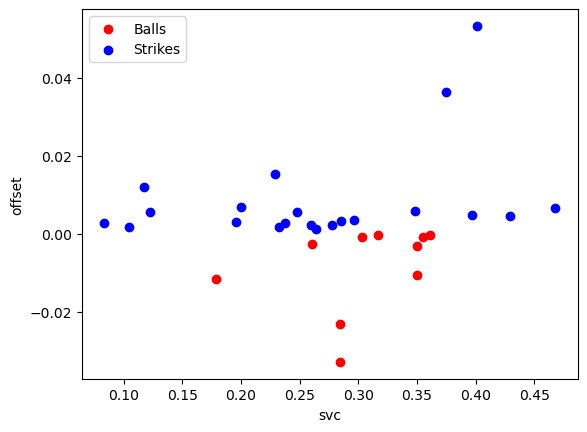

In [452]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "svc"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)

ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers

# table.groupby(["batting_team_mods"]).size()
# pd.set_option("display.max_rows", 100)  # default 60
outliers_by_pitcher = table.groupby(["pitcher_name"]).size()
pitches_by_pitcher = dfc.groupby(["pitcher_name"]).size()

outlier_fraction = pitches_by_pitcher.copy()
for pitcher in outlier_fraction.index:
    if pitcher in outliers_by_pitcher.index:
        outlier_fraction[pitcher] = outliers_by_pitcher[pitcher]/pitches_by_pitcher[pitcher]
    else:
        outlier_fraction[pitcher] = 0


outliers_by_batter = table.groupby(["batter_name"]).size()
pitches_by_batter = dfc.groupby(["batter_name"]).size()

outlier_fraction_b = pitches_by_batter.copy()
for batter in outlier_fraction_b.index:
    if batter in outliers_by_batter.index:
        outlier_fraction_b[batter] = outliers_by_batter[batter]/pitches_by_batter[batter]
    else:
        outlier_fraction_b[batter] = 0
# outlier_fraction.sort_values()
# dfc.groupby(["pitcher_name"]).size().sort_values()
print(outliers.groupby("season").size())
pd.set_option("display.max_rows", 10)  # default 60
table[#.loc[#table["pitching_team_mods"].astype(str).str.contains("FIREPROOF"),
    [
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "batter_mul",
        "event_type",
        "roll",
        "threshold",
        # "svc",
        # "ruth_vibes",
        # "pitcher_ruthlessness",
        # "batter_vibes",
        # "mox_scaled",
        # "musc_scaled",
        # "ballpark_forwardness",
        # "pitcher_coldness",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
        #  'ball_count',
        #  'strike_count',
        #  'out_count',
        # "inning",
    ]
].sort_values("offset")

In [453]:
# plt.plot(np.arange(len(outlier_fraction))/len(outlier_fraction), outlier_fraction.sort_values(), '.-')
# plt.plot(np.arange(len(outlier_fraction_b))/len(outlier_fraction_b), outlier_fraction_b.sort_values(), '.-')
# pd.set_option("display.max_rows", 300)  # default 60
# print(outlier_fraction.sort_values())
# print(outliers_by_pitcher.sort_values())
# print(outlier_fraction_b.sort_values())
pd.set_option("display.max_rows", 60)  # default 60

## Visualize Threshold

Text(0.5, 0.98, 'Season 19, Non-Flinching')

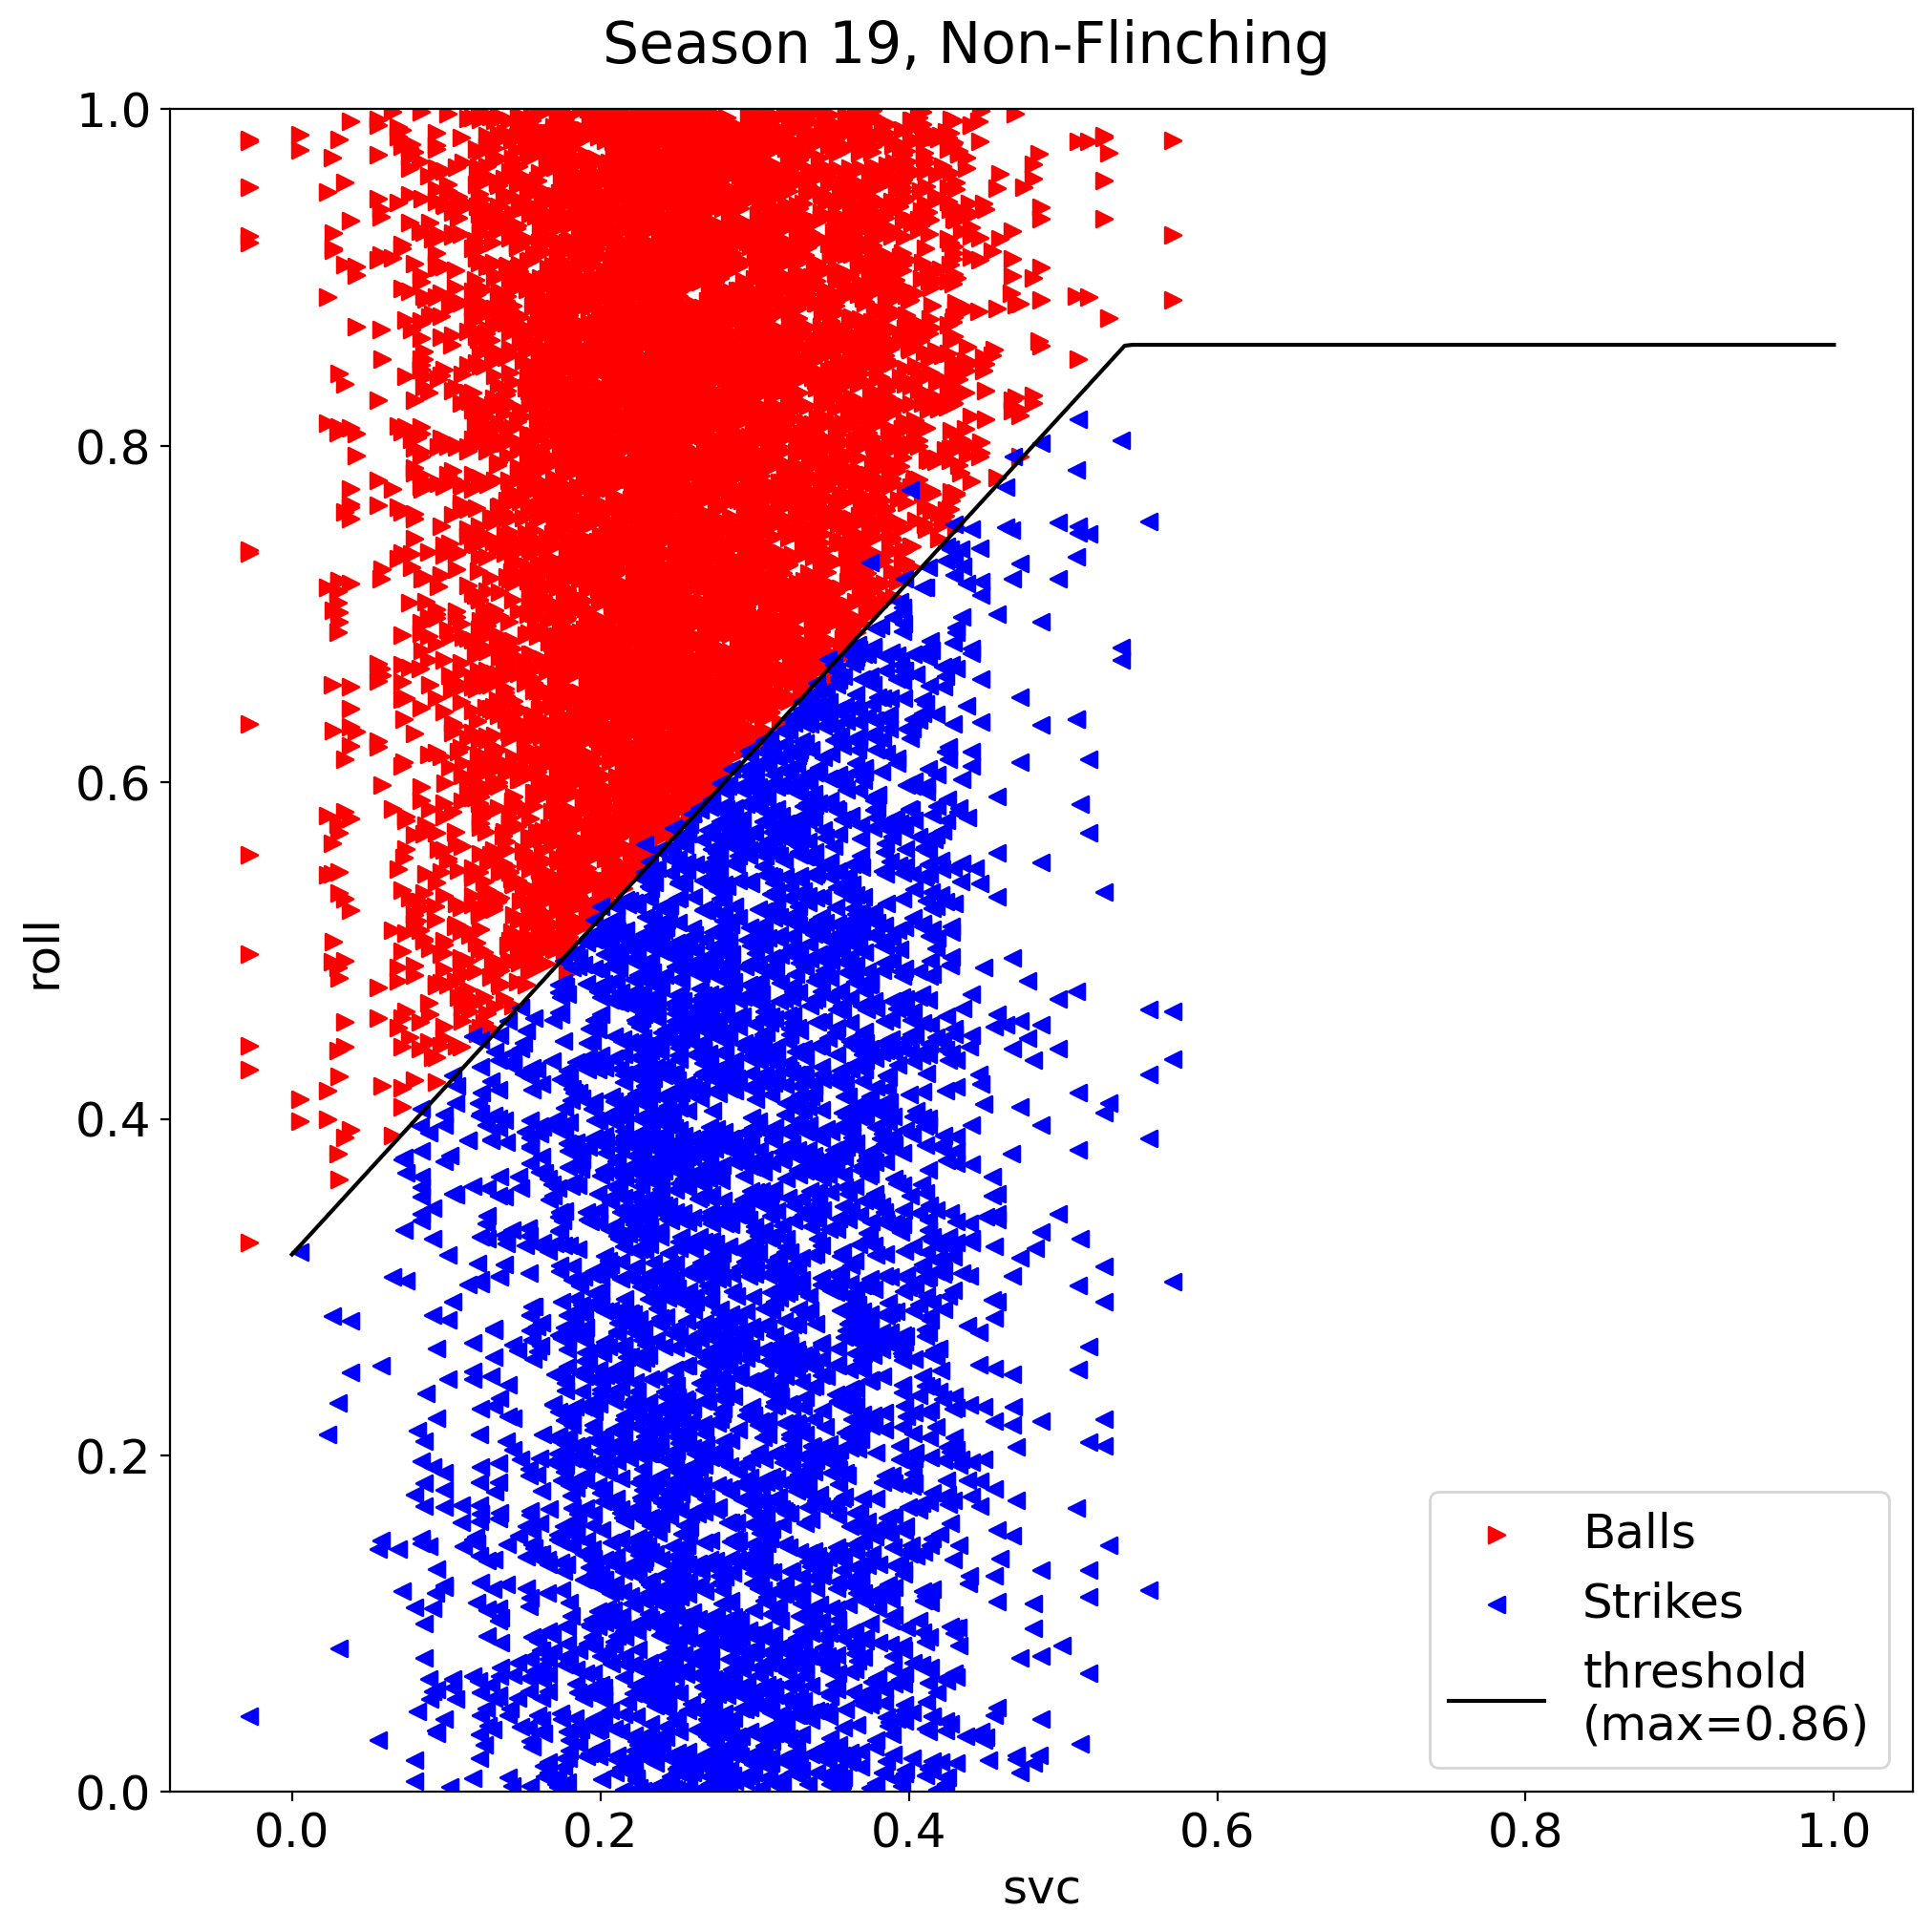

In [446]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

intercept_plot = intercept
# intercept_plot = -intercept_scaled
xline = np.linspace(0, 1, 201)
# xline = np.insert(xline, 1, 0.65)
yline = intercept_plot + xline
# yline = xline
yline[(yline > strikemax)] = strikemax

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker="<",
)
# ax.set_xlim(-0.05, 1.05)
ax.plot(xline, yline, "k", label=f"threshold\n(max={strikemax})")
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.plot(dfc["svc"].min(), 0.5, 'o')

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching")
# fig.savefig(f"../figures/strikes_s{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white', dpi=200)


In [447]:
outliers.groupby("season").size()

season
18    31
dtype: int64

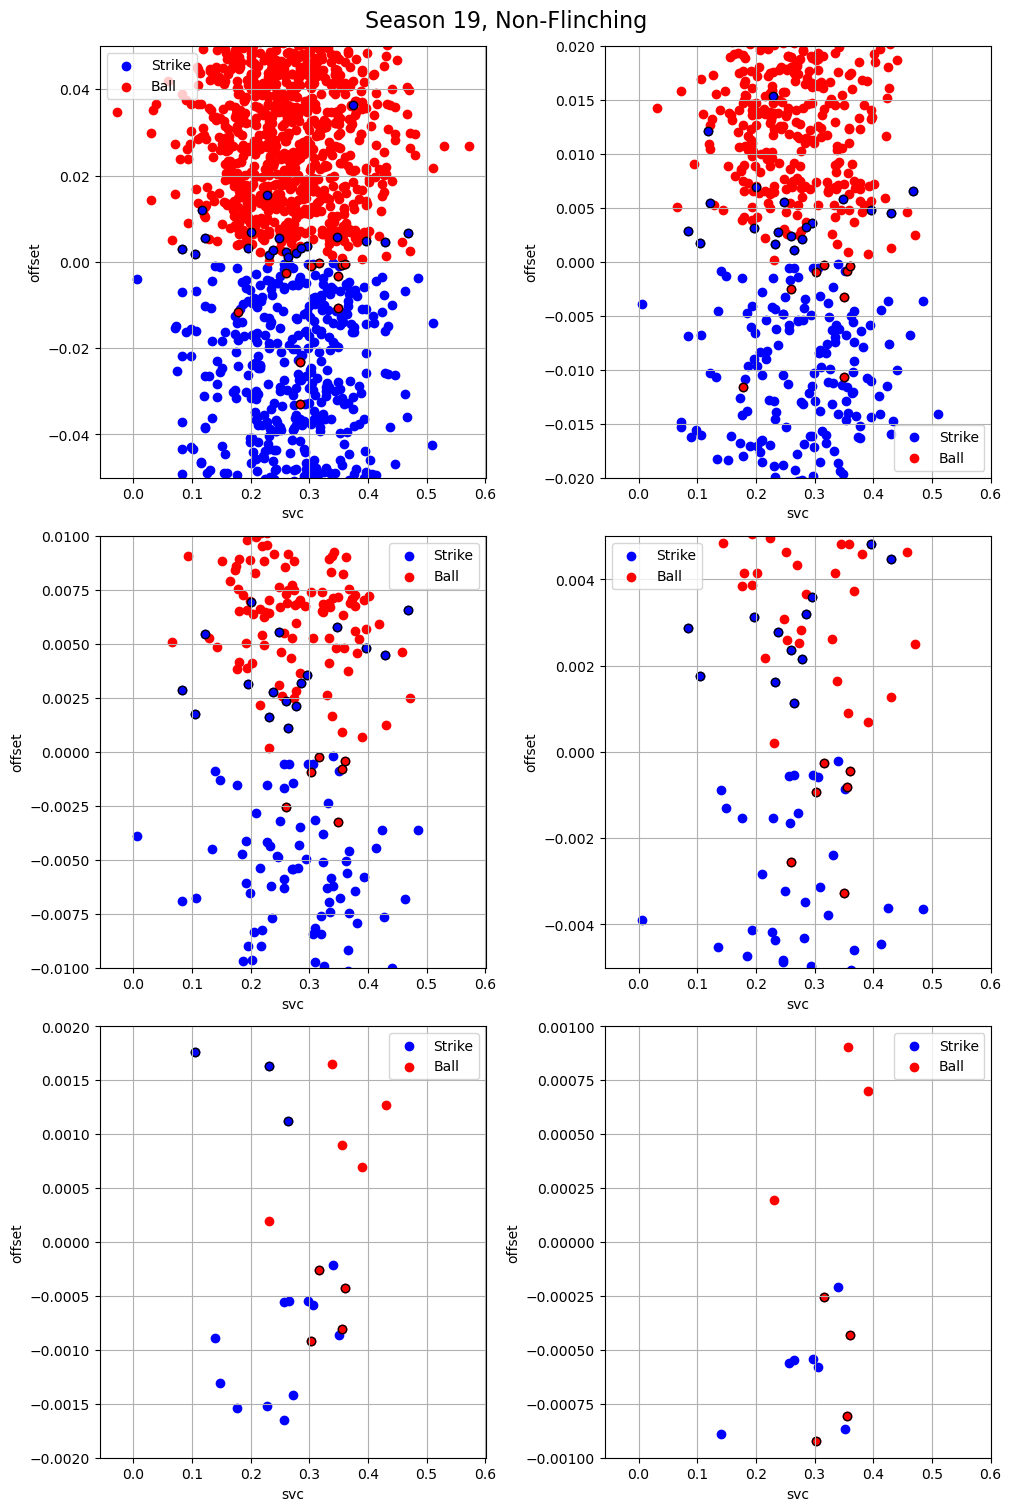

In [448]:
plt.rcParams["font.size"] = 10
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig(f"../figures/ball_strike_fit_offsets_season{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white')


In [449]:
# cutoff = 0.86 + intercept_scaled[0]
cutoff = 0.86 - intercept
print(round(cutoff, 6))
print(dfc_balls['roll'].max())
print(dfc_flinch['roll'].max())
print(dfc_strikes['roll'].max())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].min())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin())
# dfc_balls[dfc_balls['svc'] > cutoff].iloc[dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin(),:]
# print(dfc_flinch[dfc_flinch['svc'] > 0.86 + intercept_scaled[0]]['roll'].max())

0.540561
0.9999806832535514
nan
0.8154846859640053


In [450]:
print(dfc_balls['roll'].min())
print(dfc_flinch['roll'].min())
print(dfc_strikes['roll'].min())

0.3265759853975571
nan
0.0005312572265958


In [451]:
0.86 - intercept_scaled

0.5405608483576158

In [390]:
# df["svc"].min()

In [391]:
# df["svc_best"].max()

In [392]:
# df.iloc[df["svc_best"].argmax(), :][70:]

In [393]:
# dfc["threshold"] = -1 * (\
#     1.0 * -0.20 + \
#     -0.30 * dfc["ruth_scaled"] + \
#     -0.20 * dfc["ballpark_forwardness"] + \
#     -0.10 * dfc["musc_scaled"] + \
#     -0.06 * dfc["ruth_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"] + \
#     coef_scaled[0,5] * dfc["flinch"])
# dfc.loc[(dfc["threshold"] > 0.85), "threshold"] = 0.85


# dfc["offset"] = dfc["roll"] - dfc["threshold"]

# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
# print(len(outliers))

# fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 10)
# x_val = "svc"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
# ax.set_xlabel(x_val)
# ax.set_ylabel('offset')
# ax.grid()
# ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
# fig.savefig("fit_outliers.png", facecolor='white')

In [394]:
dfc_flinch.loc[:,["roll", "ruth_vibes", "pitcher_name", "svc"]].sort_values("ruth_vibes")

,roll,ruth_vibes,pitcher_name,svc


In [395]:
dfc_flinch["svc"].min()

nan

In [396]:
df_strikes = df[df["event_type"] == "StrikeLooking"]
df_flinch = df[df["event_type"] == "StrikeFlinching"]
df_balls = df[df["event_type"] == "Ball"]

In [397]:
print(df_balls['roll'].min())
print(df_flinch['roll'].min())
print(df_strikes['roll'].min())

0.009235878301657
0.0004467073582588
4.526680272132211e-05


In [398]:
print(df_balls['roll'].max())
print(df_flinch['roll'].max())
print(df_strikes['roll'].max())

0.9999952780379446
0.851811635301063
0.8567381462971488


In [399]:
game = df[(df["batter_name"] == "Zesty Yaboi")]
game

,event_type,roll,passed,batter_buoyancy,batter_divinity,batter_martyrdom,batter_moxie,batter_musclitude,batter_patheticism,batter_thwackability,...,musc_0.9,mox_0.9,musc_0.1,mox_0.1,musc_0.2,mox_0.2,musc_0.3,mox_0.3,musc_0.4,mox_0.4
50389,Ball,0.953665,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.596968,0.576956,0.944291,0.940720,0.891685,0.884954,0.842010,0.832494,0.795102,0.783143
51086,Ball,0.891168,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.596968,0.576956,0.944291,0.940720,0.891685,0.884954,0.842010,0.832494,0.795102,0.783143
51088,Ball,0.750819,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.596968,0.576956,0.944291,0.940720,0.891685,0.884954,0.842010,0.832494,0.795102,0.783143
51097,StrikeLooking,0.228379,True,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.596968,0.576956,0.944291,0.940720,0.891685,0.884954,0.842010,0.832494,0.795102,0.783143
51098,Ball,0.916080,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.596968,0.576956,0.944291,0.940720,0.891685,0.884954,0.842010,0.832494,0.795102,0.783143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693449,Ball,0.896024,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.605756,0.585449,0.945825,0.942249,0.894585,0.887832,0.846121,0.836559,0.800282,0.788246
693849,Ball,0.750297,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.606022,0.585706,0.945871,0.942295,0.894672,0.887919,0.846245,0.836681,0.800439,0.788400
693853,Ball,0.732896,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.606022,0.585706,0.945871,0.942295,0.894672,0.887919,0.846245,0.836681,0.800439,0.788400
694312,Ball,0.926665,False,0.534671,0.996225,0.751703,0.533062,0.553645,0.715727,0.452497,...,0.606022,0.585706,0.945871,0.942295,0.894672,0.887919,0.846245,0.836681,0.800439,0.788400


In [400]:
# X = dfc[["passed",
#          "roll",
#          # "roll_mod",
#          # "roll_log",
#          "ruth_vibes",
#          "cold_vibes",
#          # "pitcher_vibes",
#          # "ruth_cold",
#          # "opw_vibes",
#          # "shakes_vibes",
#          # "supp_vibes",
#          # "unthwk_vibes",
#          "ballpark_forwardness",
#          # 'ballpark_grandiosity',
#          # 'ballpark_fortification',
#          # 'ballpark_obtuseness',
#          # 'ballpark_ominousness',
#          # 'ballpark_inconvenience',
#          # 'ballpark_viscosity',
#          # 'ballpark_mysticism',
#          # 'ballpark_elongation',
#          "musc_scaled",
#          "mox_scaled",
#          "musc_mox",
#          "musc_pow",
#          "mox_pow",
#          # "musc_log",
#          # "mox_log",
#          # "musc_mox_log",
#          # "mox_vibes",
#          # "fielder_roll",
#          # "batter_buoyancy",
#          # "batter_divinity",
#          # "batter_martyrdom",
#          # "batter_moxie",
#          # "batter_musclitude",
#          # "batter_patheticism",
#          # "batter_thwackability",
#          # "batter_tragicness",
#          # "batter_coldness",
#          # "batter_overpowerment",
#          # "batter_ruthlessness",
#          # "batter_shakespearianism",
#          # "batter_suppression",
#          # "batter_unthwackability",
#          # "batter_anticapitalism",
#          # "batter_chasiness",
#          # "batter_omniscience",
#          # "batter_tenaciousness",
#          # "batter_watchfulness",
#          # "batter_base_thirst",
#          # "batter_continuation",
#          # "batter_ground_friction",
#          # "batter_indulgence",
#          # "batter_laserlikeness",
#          # "batter_pressurization",
#          # "batter_cinnamon",
#          # "batter_vibes",
#          # "batting_team_hype",
#          # "pitching_team_hype",
#          # "inning",
#          ]].copy()

## Grid Search

In [404]:
powers = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9",
    "1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0",
         "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"]
scores = np.zeros((len(powers), len(powers)))
for i, pow1 in enumerate(powers):
    for j, pow2 in enumerate(powers):
        # print("=================================================")
        # print("musc_"+pow1, "mox_"+pow2)
        # print("=================================================")
        dfc["musc_pow"] = dfc["musc_"+pow1]
        dfc["mox_pow"] = dfc["mox_"+pow2]
        dfc["musc_mox"] = dfc["musc_pow"] * dfc["mox_pow"]

        # X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
        X = dfc[["passed",
                 "roll",
                 # "roll_mod",
                 # "roll_log",
                 "ruth_vibes",
                 "cold_vibes",
                 # "ruth_cold",
                 "ballpark_forwardness",
                 # "musc_scaled",
                 # "mox_scaled",
                 "musc_mox",
                 "musc_pow",
                 "mox_pow",
                 # "musc_log",
                 # "mox_log",
                 # "musc_mox_log",
                 # "mox_vibes",
                 # "batting_team_hype",
                 # "pitching_team_hype",
                 ]].copy()
        X = X[X["roll"] < 0.86]
        # attributes may or may not be allowed to go negative with items. exclude cases where this might happen
        # and which would throw off the non-integer power i'm testing
        X = X[~np.isnan(X.iloc[:,-1])]
        X = X[~np.isnan(X.iloc[:,-2])]
        # X = X[X["roll_mod"] > 0]
        # X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
        # X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
        # X = dfc[['roll', 'pitcher_ruthlessness']]
        y = X["passed"]
        X = X.drop(["passed"], axis=1)
        # X = X.drop(["roll"], axis=1)
        # X = X.drop(["roll_mod"], axis=1)

        pin_intercept = None
        # pin_intercept = 0.34
        pins = [
            # (-0.075, "batting_team_hype"),
            # (0.060, "pitching_team_hype"),
            # (0.29, "ruth_cold"),
            # (0.12, "ballpark_forwardness"),
            # (0.075, "musc_scaled"),
            # (-0.08, "mox_scaled"),
            # (0.08, "musc_mox"),
        ]
        for val, var in pins:
            X["roll_log"] -= X[var] * val
            X = X.drop(var, axis=1)

        sc = StandardScaler(with_mean=False)
        X2 = sc.fit_transform(X)
        if pin_intercept is not None:
            X2[:, 0] -= pin_intercept / sc.scale_[0]

        # print(X["roll"].max())
        # print(X.shape)


        trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                                   tol=1e-10).fit(X2, y)
        predictionsvm = trainedsvm.predict(X2)
        # print(confusion_matrix(y, predictionsvm))
        # print(classification_report(y, predictionsvm))
        sc.inverse_transform(trainedsvm.coef_)
        trainedsvm.coef_
        sc.scale_
        scores[i, j] = trainedsvm.score(X2, y)
        # print(scores[i, j])

# print the last one, just for fun
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
            
print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        pass

0.31685179859202023 , intercept
(0.2649458340415102, 'ruth_vibes')
(0.03389541582391039, 'cold_vibes')
(0.09852512067367294, 'ballpark_forwardness')
(0.0020822526595395325, 'musc_mox')
(0.026218766128730402, 'musc_pow')
(-0.0390122265354642, 'mox_pow')


Text(0, 0.5, 'musclitude exponent')

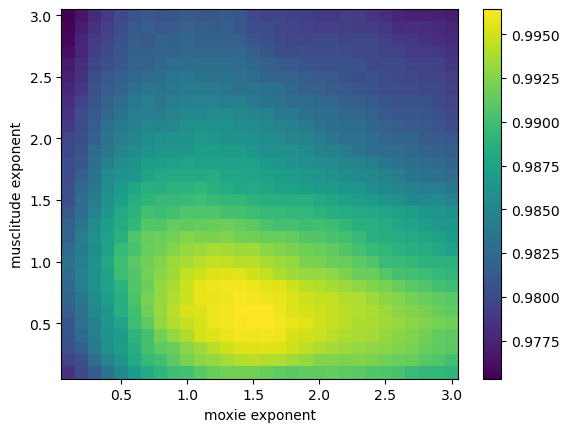

In [405]:
xx = np.array([float(i) for i in powers])
plt.pcolormesh(xx, xx, scores)#, vmin=0.9935, vmax=0.997)
plt.colorbar()
plt.xlabel("moxie exponent")
plt.ylabel("musclitude exponent")

In [406]:
print(scores.max())
print(np.unravel_index(scores.argmax(), scores.shape))
print(xx[np.unravel_index(scores.argmax(), scores.shape)[0]], xx[np.unravel_index(scores.argmax(), scores.shape)[1]])
scores[0:3,:]

0.9964416896235078
(4, 14)
0.5 1.5


array([[0.97842057, 0.98002755, 0.98140496, 0.98324151, 0.98519284,
        0.98679982, 0.98806244, 0.9890955 , 0.98989899, 0.99013422,
        0.99093205, 0.99162075, 0.99196511, 0.99196511, 0.99196511,
        0.99162075, 0.9912764 , 0.99104683, 0.9912764 , 0.9912814 ,
        0.99139118, 0.99116162, 0.99104683, 0.99070248, 0.9905877 ,
        0.99035813, 0.98966942, 0.98932507, 0.98932507, 0.98910176],
       [0.9796832 , 0.98048669, 0.98278237, 0.98484848, 0.98645546,
        0.98806244, 0.98943985, 0.99001377, 0.99116162, 0.99208443,
        0.99288338, 0.99299816, 0.99357208, 0.99403122, 0.99414601,
        0.99403122, 0.99391644, 0.9934573 , 0.99311295, 0.99242859,
        0.99242424, 0.99230946, 0.99242424, 0.99219467, 0.99185032,
        0.99162075, 0.99150597, 0.99093205, 0.99070248, 0.99013422],
       [0.98048669, 0.98174931, 0.98393021, 0.98588154, 0.98702938,
        0.98852158, 0.99024334, 0.99116162, 0.99162075, 0.99277274,
        0.99334252, 0.99426079, 0.99483471, 0.